--- BẮT ĐẦU VẼ CÁC BIỂU ĐỒ NÂNG CAO (INSIGHTFUL COMPARISON) ---
📂 Output Directory: d:\BTL\BBB\2526-LTXLDL-Project4-AIT2006-2-4.4\figures

--- LOADING DATA ---
✅ Loaded: Berlin (13945 rows)
✅ Loaded: Brussels (6542 rows)
✅ Loaded: Paris (86064 rows)

--- GENERATING PLOTS ---


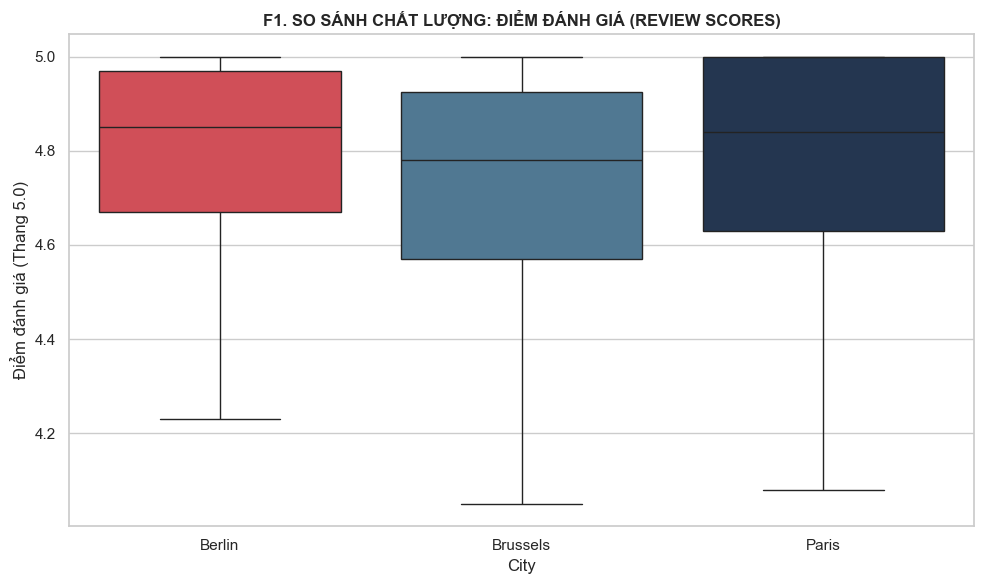

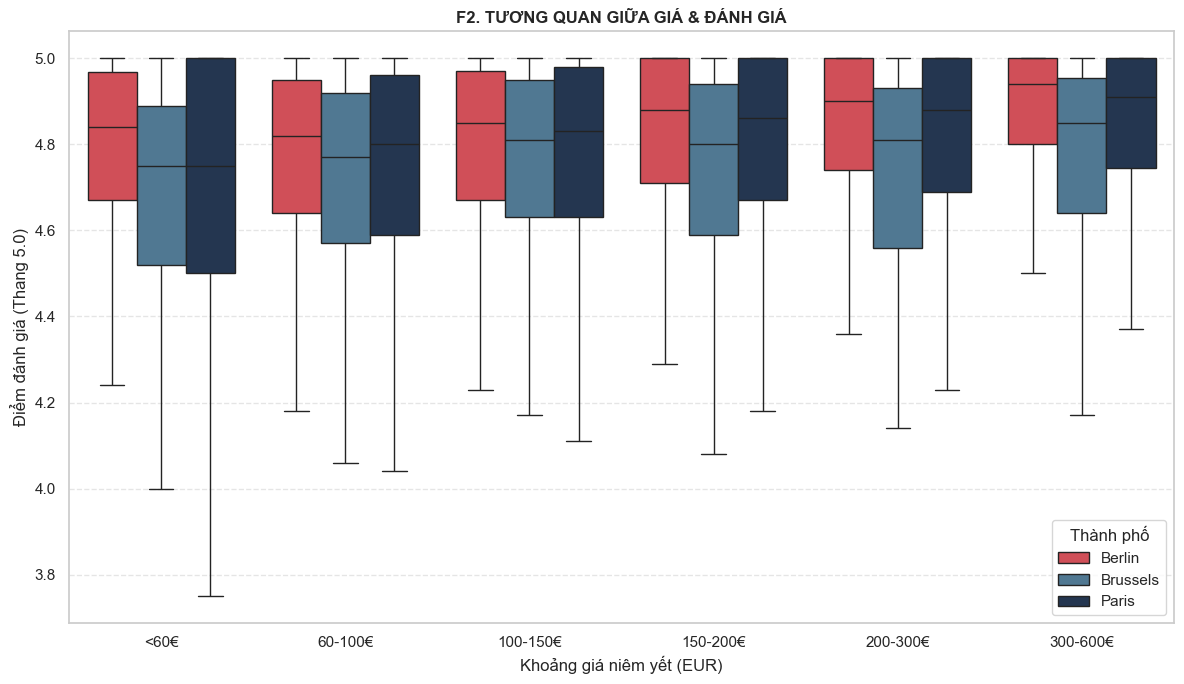

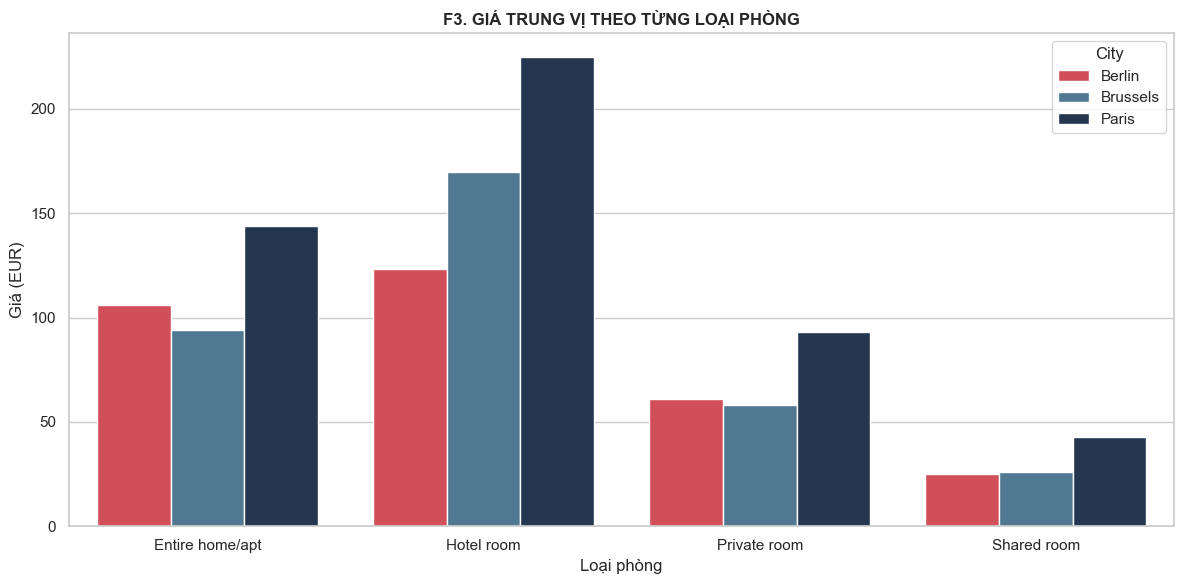

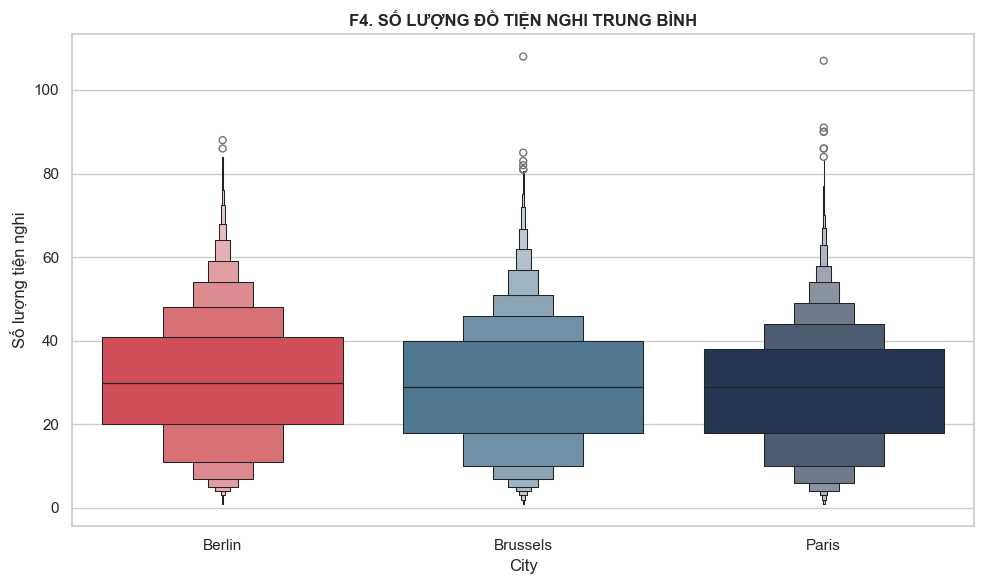

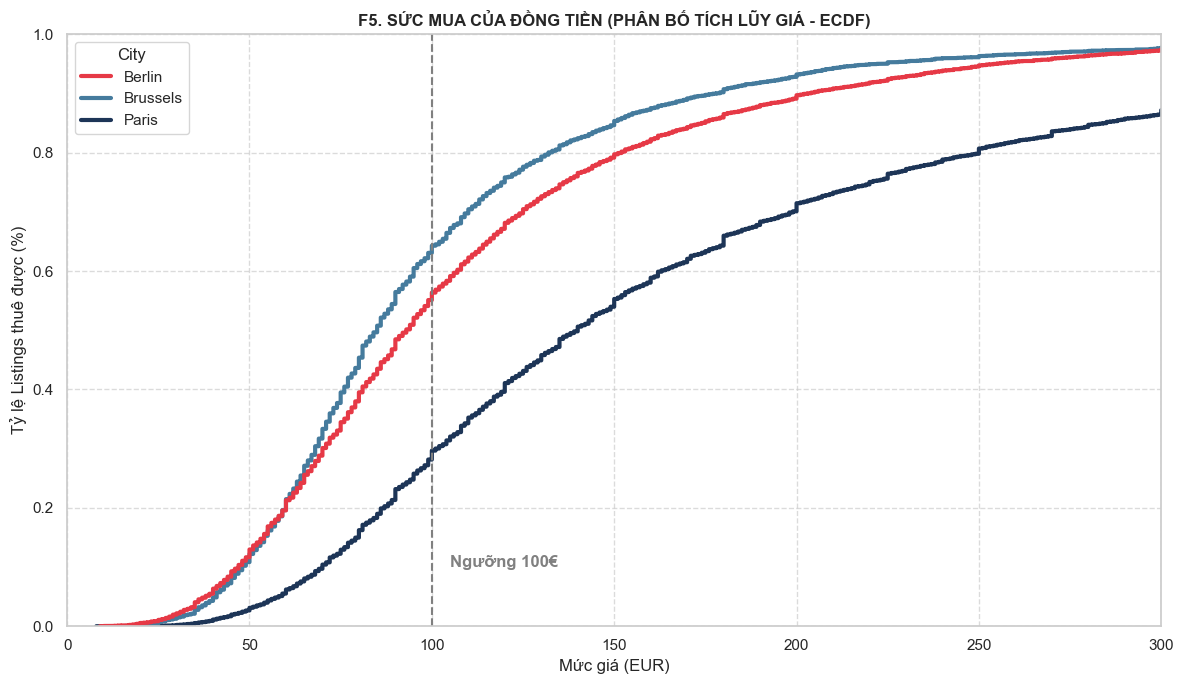

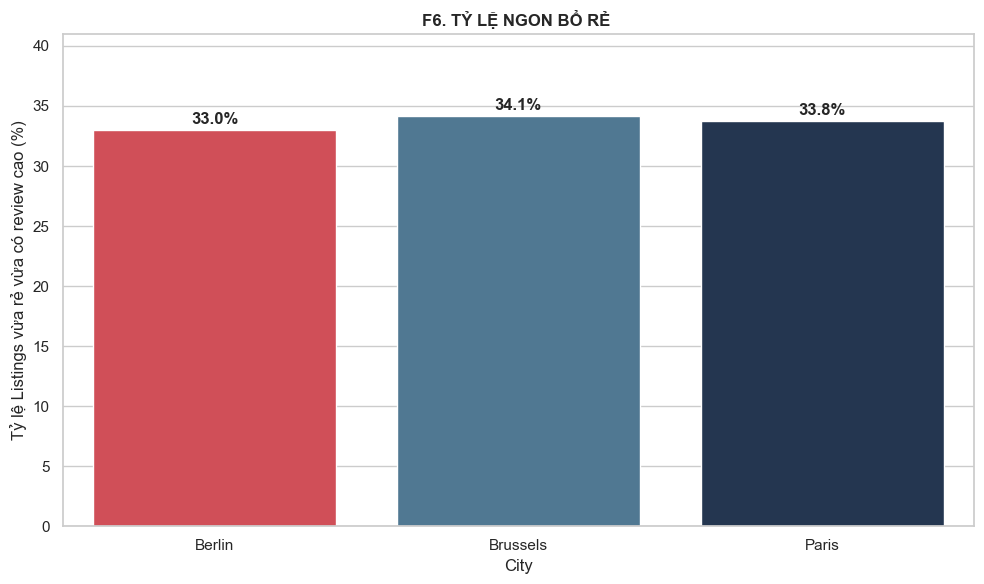

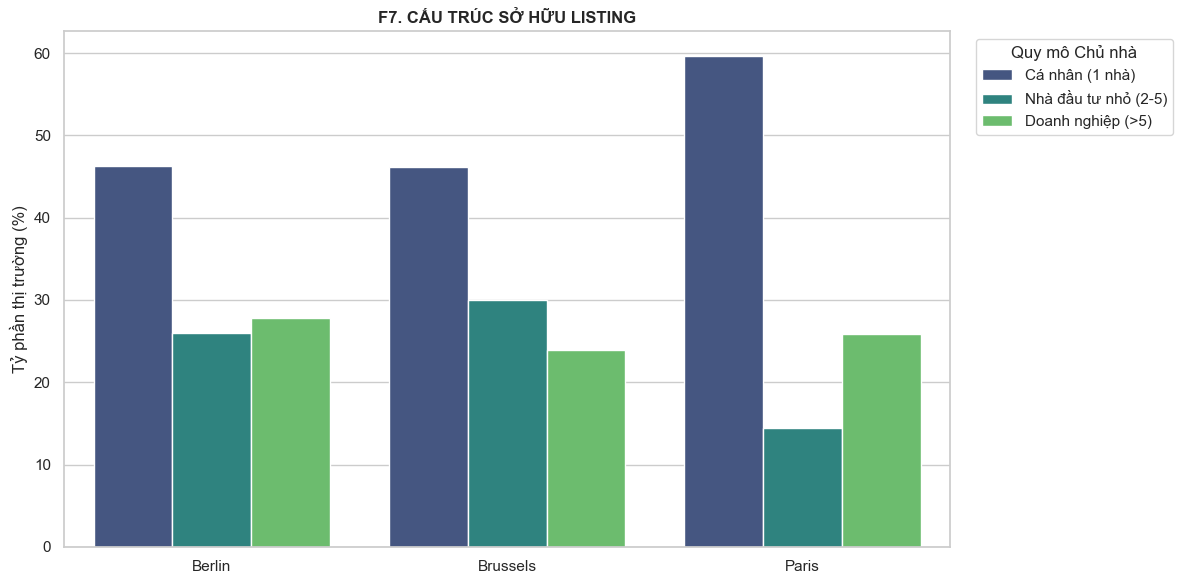

✅ ĐÃ HOÀN TẤT!.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from datetime import datetime

# ==============================================================================
# 0. CONFIG & SETUP
# ==============================================================================
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

# Visual Style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 7), 'font.size': 12})

# City Colors Palette (Consistent with Summary_Visualization)
CITY_COLORS = {
    'Berlin': '#E63946',   # Red
    'Brussels': '#457B9D', # Light Blue
    'Paris': '#1D3557'     # Dark Blue
}

print("--- BẮT ĐẦU VẼ CÁC BIỂU ĐỒ NÂNG CAO (INSIGHTFUL COMPARISON) ---")
print(f"📂 Output Directory: {os.path.abspath(FIGURES_DIR)}")

# ==============================================================================
# 1. HELPER FUNCTIONS
# ==============================================================================

def safe_capitalize_city(name):
    """Normalize city name from folder path."""
    if not isinstance(name, str): return name
    return name.split(os.sep)[-1].split('_')[0].split()[0].capitalize()

def parse_flexible_date(s):
    """Robust date parser for various folder formats."""
    if pd.isna(s): return pd.NaT
    s = str(s).strip()
    formats = ["%d %B, %Y", "%d %B %Y", "%Y-%m-%d", "%d-%m-%Y"]
    for fmt in formats:
        try: return pd.to_datetime(datetime.strptime(s, fmt))
        except: continue
    return pd.to_datetime(s, dayfirst=True, errors='coerce')

def load_latest_listings():
    """
    Aggressively search for 'listings_processed.csv' in city folders.
    Returns: DataFrame containing concatenated data for all 3 cities.
    """
    df_list = []
    target_cities = ['berlin', 'brussels', 'paris']
    
    if not os.path.exists(PROCESSED_DIR):
        print("❌ ERROR: Processed directory not found.")
        return pd.DataFrame()

    for target in target_cities:
        found = False
        # Iterate over all folders in processed dir
        for folder_name in os.listdir(PROCESSED_DIR):
            if target in folder_name.lower():
                city_path = os.path.join(PROCESSED_DIR, folder_name)
                if not os.path.isdir(city_path): continue
                
                # Recursive search for the csv file
                search_pattern = os.path.join(city_path, '**', 'listings_processed.csv')
                found_files = glob.glob(search_pattern, recursive=True)
                
                if found_files:
                    # Pick the first one found (usually the latest if sorted, but ensure existence first)
                    file_path = found_files[0] 
                    try:
                        df = pd.read_csv(file_path, low_memory=False)
                        if not df.empty and 'price_numeric' in df.columns:
                            df['City'] = target.capitalize()
                            df_list.append(df)
                            found = True
                            print(f"✅ Loaded: {target.capitalize()} ({len(df)} rows)")
                            break
                    except: pass
        if not found:
            print(f"⚠️ Warning: No data found for {target}")
            
    return pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()

# ==============================================================================
# 2. DATA LOADING & PREPROCESSING
# ==============================================================================
print("\n--- LOADING DATA ---")
df_detail = load_latest_listings()

if not df_detail.empty:
    # 2.1 Convert Types
    df_detail['price_numeric'] = pd.to_numeric(df_detail['price_numeric'], errors='coerce')
    
    # 2.2 Filtering (Clean Data)
    df_clean = df_detail.dropna(subset=['price_numeric'])
    # Filter reasonable price range for fair comparison
    df_clean = df_clean[(df_clean['price_numeric'] > 0) & (df_clean['price_numeric'] < 600)]
    
    # 2.3 Feature Engineering
    # Amenities Count
    if 'amenities' in df_clean.columns:
        df_clean['amenities_count'] = df_clean['amenities'].astype(str).apply(lambda x: x.count(',') + 1)
    
    # Host Categories (For F7)
    if 'calculated_host_listings_count' in df_clean.columns:
        def categorize_host(n):
            if n == 1: return 'Cá nhân (1 nhà)'
            elif n <= 5: return 'Nhà đầu tư nhỏ (2-5)'
            else: return 'Doanh nghiệp (>5)'
        df_clean['host_type_category'] = df_clean['calculated_host_listings_count'].apply(categorize_host)
else:
    df_clean = pd.DataFrame()
    print("❌ CRITICAL: No data loaded.")

# ==============================================================================
# 3. VISUALIZATION (F1 - F7)
# ==============================================================================

if not df_clean.empty:
    print("\n--- GENERATING PLOTS ---")
    
    # F1: Quality Comparison (Boxplot)
    # -------------------------------------------------------
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clean, x='City', y='review_scores_rating', 
                hue='City', palette=CITY_COLORS, showfliers=False, legend=False)
    plt.title('F1. SO SÁNH CHẤT LƯỢNG: ĐIỂM ĐÁNH GIÁ (REVIEW SCORES)', fontweight='bold')
    plt.ylabel('Điểm đánh giá (Thang 5.0)')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'F01_Quality_Scores.pdf'))
    plt.show()

    
    # --- F2 Tương quan Giá & Chất lượng (Dạng Boxplot) ---
    # Thay vì Scatter plot rối mắt, ta dùng Boxplot theo từng khoảng giá để dễ so sánh
    plt.figure(figsize=(12, 7))
    
    # 1. Chia giá thành các khoảng (Bins) dễ hiểu
    price_bins = [0, 60, 100, 150, 200, 300, 600]
    bin_labels = ['<60€', '60-100€', '100-150€', '150-200€', '200-300€', '300-600€']
    
    # Tạo cột phân nhóm mới
    df_clean['price_range_group'] = pd.cut(df_clean['price_numeric'], bins=price_bins, labels=bin_labels)
    
    # 2. Vẽ Boxplot
    sns.boxplot(data=df_clean, x='price_range_group', y='review_scores_rating', 
                hue='City', palette=CITY_COLORS, showfliers=False) 
    
    plt.title('F2. TƯƠNG QUAN GIỮA GIÁ & ĐÁNH GIÁ', fontweight='bold')
    plt.xlabel('Khoảng giá niêm yết (EUR)')
    plt.ylabel('Điểm đánh giá (Thang 5.0)')
    plt.legend(title='Thành phố', loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'F02_Price_Quality_Boxplot.pdf'))
    plt.show()
    # F3: Price by Room Type (Grouped Bar)
    # -------------------------------------------------------
    price_room = df_clean.groupby(['City', 'room_type'])['price_numeric'].median().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(data=price_room, x='room_type', y='price_numeric', 
                hue='City', palette=CITY_COLORS)
    plt.title('F3. GIÁ TRUNG VỊ THEO TỪNG LOẠI PHÒNG', fontweight='bold')
    plt.ylabel('Giá (EUR)')
    plt.xlabel('Loại phòng')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'F03_Price_RoomType.pdf'))
    plt.show()

    # F4: Amenities Count (Boxplot)
    # -------------------------------------------------------
    if 'amenities_count' in df_clean.columns:
        plt.figure(figsize=(10, 6))
        sns.boxenplot(data=df_clean, x='City', y='amenities_count', 
                      hue='City', palette=CITY_COLORS, legend=False)
        plt.title('F4. SỐ LƯỢNG ĐỒ TIỆN NGHI TRUNG BÌNH', fontweight='bold')
        plt.ylabel('Số lượng tiện nghi')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'F04_Amenities.pdf'))
        plt.show()

    # F5: Purchasing Power (ECDF Plot)
    # -------------------------------------------------------
    plt.figure(figsize=(12, 7))
    sns.ecdfplot(data=df_clean, x='price_numeric', hue='City', palette=CITY_COLORS, linewidth=3)
    plt.title('F5. SỨC MUA CỦA ĐỒNG TIỀN (PHÂN BỐ TÍCH LŨY GIÁ - ECDF)', fontweight='bold')
    plt.xlabel('Mức giá (EUR)')
    plt.ylabel('Tỷ lệ Listings thuê được (%)')
    plt.xlim(0, 300)
    plt.grid(True, linestyle='--', alpha=0.7)
    # Reference line
    plt.axvline(100, color='gray', linestyle='--')
    plt.text(105, 0.1, 'Ngưỡng 100€', color='gray', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'F05_Purchasing_Power.pdf'))
    plt.show()

    # F6: Hidden Gems (Bar Chart)
    # -------------------------------------------------------
    gem_data = []
    for city in df_clean['City'].unique():
        city_df = df_clean[df_clean['City'] == city]
        median_price = city_df['price_numeric'].median()
        # Logic: High rating (>4.5) AND Low price (< median)
        gems = city_df[(city_df['review_scores_rating'] >= 4.5) & (city_df['price_numeric'] < median_price)]
        pct_gems = (len(gems) / len(city_df)) * 100
        gem_data.append({'City': city, 'Gem_Rate': pct_gems})
    
    df_gems = pd.DataFrame(gem_data)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_gems, x='City', y='Gem_Rate', 
                hue='City', palette=CITY_COLORS, legend=False)
    plt.title('F6. TỶ LỆ NGON BỔ RẺ ', fontweight='bold')
    plt.ylabel('Tỷ lệ Listings vừa rẻ vừa có review cao (%)')
    plt.ylim(0, max(df_gems['Gem_Rate'])*1.2)
    # Add labels
    for i, r in df_gems.iterrows():
        plt.text(i, r.Gem_Rate + 0.5, f"{r.Gem_Rate:.1f}%", ha='center', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'F06_Hidden_Gems.pdf'))
    plt.show()

    # F7: Host Structure (Stacked Bar / Grouped Bar)
    # -------------------------------------------------------
    if 'host_type_category' in df_clean.columns:
        host_counts = df_clean.groupby(['City', 'host_type_category'], observed=False).size().reset_index(name='count')
        total_city = df_clean.groupby('City')['host_type_category'].count().reset_index(name='total')
        host_counts = host_counts.merge(total_city, on='City')
        host_counts['pct'] = host_counts['count'] / host_counts['total'] * 100
        
        order_hue = ['Cá nhân (1 nhà)', 'Nhà đầu tư nhỏ (2-5)', 'Doanh nghiệp (>5)']
        
        plt.figure(figsize=(12, 6))
        # Use viridis for distinct host types
        sns.barplot(data=host_counts, x='City', y='pct', hue='host_type_category', 
                    hue_order=order_hue, palette='viridis')
        plt.title('F7. CẤU TRÚC SỞ HỮU LISTING', fontweight='bold')
        plt.ylabel('Tỷ phần thị trường (%)')
        plt.xlabel('')
        plt.legend(title='Quy mô Chủ nhà', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'F07_Host_Structure.pdf'))
        plt.show()

print("✅ ĐÃ HOÀN TẤT!.")